# Linear Regression for Asset Pricing
## Project 2: APT (Arbitrage Price Theory)
### Milestone 3: Understanding the APT Model

In [6]:
import pandas as pd          ## Data engine
import numpy as np

import yfinance as yf        ## Finance APIS
from fredapi import Fred

import statsmodels.api as sm ## Model

import seaborn as sns        ## Visualization
from matplotlib import pyplot as plt

# Data set #1 - Recent data

<b>Tickers</b>: semiconductor/AI + S&P500\
<b>Period</b>: 2 most recent years\
<b>Periodicity</b>: Monthly

#### Persisted in prior milestone

In [7]:
### Restore our prior data set
scen1_inputs = pd.read_csv('p2m2_scen1_returns.csv')\
                .set_index('fiscal_end')

### Keep only excess returns for model
keepers1 = [c for c in scen1_inputs.columns if c.startswith('excess')]
scen1_inputs = scen1_inputs[keepers1]
scen1_inputs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 2023-02-28 to 2024-11-30
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   excess_return_AMD                  22 non-null     float64
 1   excess_return_INTC                 22 non-null     float64
 2   excess_return_MSFT                 22 non-null     float64
 3   excess_return_NVDA                 22 non-null     float64
 4   excess_return_SPY                  22 non-null     float64
 5   excess_return_potential_inflation  22 non-null     float64
 6   excess_return_industrial_prod      22 non-null     float64
 7   excess_return_risk_free            22 non-null     float64
dtypes: float64(8)
memory usage: 1.5+ KB


# Data set #2 - Long-term data

<b>Tickers</b>: automotive + S&P500\
<b>Period</b>: 80 months ending Sept 2021\
<b>Periodicity</b>: Monthly

In [8]:
# Setup
tickers = ['GM','F','TM','TSLA','^GSPC']


### dates and interval
_start = '2015-01-01'
_end = '2021-09-01'
_interval = '1mo'

In [9]:
autostock=yf.download(tickers
                            , start=_start
                            , end=_end
                            , interval=_interval)
scen2_stocks=autostock['Close']
scen2_stocks=scen2_stocks.rename({'^GSPC':'GSPC'},axis='columns')
scen2_stocks.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed


Ticker,F,GM,TM,TSLA,GSPC
Date,,,,,
2015-01-01,8.494987,25.381149,121.128883,13.573333,1994.989990
2015-02-01,9.532599,29.030365,127.258156,13.556000,2104.500000
2015-03-01,9.415920,29.178202,131.507324,12.584667,2067.889893
2015-04-01,9.217567,27.503654,132.553024,15.070000,2085.510010
2015-05-01,8.933474,28.217520,131.475601,16.719999,2107.389893


In [10]:
## Verify the same number of months
scen2_stocks[['GM','F','TM','TSLA']].count()

Ticker
GM      80
F       80
TM      80
TSLA    80
dtype: int64

In [11]:
scen2_stocks.head()

Ticker,F,GM,TM,TSLA,GSPC
Date,,,,,
2015-01-01,8.494987,25.381149,121.128883,13.573333,1994.989990
2015-02-01,9.532599,29.030365,127.258156,13.556000,2104.500000
2015-03-01,9.415920,29.178202,131.507324,12.584667,2067.889893
2015-04-01,9.217567,27.503654,132.553024,15.070000,2085.510010
2015-05-01,8.933474,28.217520,131.475601,16.719999,2107.389893


In [6]:
### persist
scen2_stocks.to_csv('scen2_stocks.csv')

### FRED

In [ ]:
fredapi = 'aal392alkjdfa90823la'

In [9]:
fred = Fred(api_key = fredapi)
### industrial production
ind = fred.get_series('INDPRO')
### potential inflation
inf = fred.get_series('CPIEALL')
### risk-free rate
risk_free = fred.get_series('GS1')

In [10]:
### dates are first day for whole month
ind_1 = ind[_start:_end]
inf_1 = inf[_start:_end]
rf_1 = risk_free[_start:_end]

In [11]:
### format and merge datafarmes
ind_0 = ind_1.reset_index()\
    .rename({'index':'month'
             , 0:'industrial_prod'}
            ,axis=1)

inf_0 = inf_1.reset_index()\
    .rename({'index':'month'
             , 0:'potential_inflation'}
            ,axis=1)

rf_0 = rf_1.reset_index()\
    .rename({'index':'month'
             , 0:'risk_free'}
            ,axis=1)


In [12]:
scen2_fred = inf_0.merge(ind_0, left_index=True, right_index=True)\
                .merge(rf_0, left_index=True, right_index=True)
scen2_fred = scen2_fred[['month','potential_inflation'
                        ,'industrial_prod','risk_free']]
scen2_fred.head()

,month,potential_inflation,industrial_prod,risk_free
0,2015-01-01,253.383,102.7923,0.20
1,2015-02-01,254.369,102.1366,0.22
2,2015-03-01,255.612,101.7869,0.25
3,2015-04-01,256.168,101.2255,0.23
4,2015-05-01,257.238,100.7675,0.24


In [13]:
scen2_fred.tail()

,month,potential_inflation,industrial_prod,risk_free
76,2021-05-01,292.759,99.1867,0.05
77,2021-06-01,295.083,99.6483,0.07
78,2021-07-01,296.456,100.0668,0.08
79,2021-08-01,297.114,100.0412,0.07
80,2021-09-01,297.988,98.9955,0.08


In [14]:
### Persist
scen2_fred.to_csv('scen2_fred.csv')

### Read data back in

In [15]:
del(scen2_fred)
del(scen2_stocks)
scen2_stocks = pd.read_csv("scen2_stocks.csv",index_col='Date')
scen2_fred = pd.read_csv("scen2_fred.csv",index_col='month')\
    .drop('Unnamed: 0',axis=1)

In [44]:
scen2_stocks.head()

,F,GM,TM,TSLA,GSPC
Date,,,,,
2015-01-01,8.494989,25.381149,121.128883,13.573333,1994.989990
2015-02-01,9.532598,29.030361,127.258156,13.556000,2104.500000
2015-03-01,9.415921,29.178200,131.507324,12.584667,2067.889893
2015-04-01,9.217568,27.503645,132.553024,15.070000,2085.510010
2015-05-01,8.933468,28.217524,131.475601,16.719999,2107.389893


In [45]:
scen2_fred.head()

,potential_inflation,industrial_prod,risk_free
month,,,
2015-01-01,253.383,102.7923,0.20
2015-02-01,254.369,102.1366,0.22
2015-03-01,255.612,101.7869,0.25
2015-04-01,256.168,101.2255,0.23
2015-05-01,257.238,100.7675,0.24


In [73]:
### Merge ....
pd.set_option('max_colwidth',50)
scen2 = scen2_stocks.merge(scen2_fred, left_on='Date'
                        , right_on='month', how = 'inner')
scen2.rename({'potential_inflation':'inflation',
              'industrial_prod':'ind',
              'risk_free':'r'},axis=1).round(2).head()

,F,GM,TM,TSLA,GSPC,inflation,ind,r
0,8.49,25.38,121.13,13.57,1994.99,253.38,102.79,0.20
1,9.53,29.03,127.26,13.56,2104.50,254.37,102.14,0.22
2,9.42,29.18,131.51,12.58,2067.89,255.61,101.79,0.25
3,9.22,27.50,132.55,15.07,2085.51,256.17,101.23,0.23
4,8.93,28.22,131.48,16.72,2107.39,257.24,100.77,0.24


In [74]:
### ... and calculate rate of change
scen2_returns = scen2.pct_change().dropna()
scen2_returns.rename({'potential_inflation':'inflation',
              'industrial_prod':'ind',
              'risk_free':'r'},axis=1).round(2).head()

,F,GM,TM,TSLA,GSPC,inflation,ind,r
1,0.12,0.14,0.05,-0.00,0.05,0.0,-0.01,0.10
2,-0.01,0.01,0.03,-0.07,-0.02,0.0,-0.00,0.14
3,-0.02,-0.06,0.01,0.20,0.01,0.0,-0.01,-0.08
4,-0.03,0.03,-0.01,0.11,0.01,0.0,-0.00,0.04
5,-0.01,-0.07,-0.03,0.07,-0.02,0.0,-0.00,0.17


In [52]:
### Calculate excess returns
cols = scen2_returns.columns
for i in cols:
    scen2_returns["excess_return_"+str(i)] = scen2_returns[i] - scen2_returns['risk_free']
scen2_returns.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79 entries, 1 to 79
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   F                                  79 non-null     float64
 1   GM                                 79 non-null     float64
 2   TM                                 79 non-null     float64
 3   TSLA                               79 non-null     float64
 4   GSPC                               79 non-null     float64
 5   potential_inflation                79 non-null     float64
 6   industrial_prod                    79 non-null     float64
 7   risk_free                          79 non-null     float64
 8   excess_return_F                    79 non-null     float64
 9   excess_return_GM                   79 non-null     float64
 10  excess_return_TM                   79 non-null     float64
 11  excess_return_TSLA                 79 non-null     float64
 12  e

In [34]:
### Keep only excess returns for model
keepers = [c for c in scen2_returns.columns if c.startswith('excess')]
scen2_inputs = scen2_returns[keepers]
scen2_inputs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   excess_return_F                    79 non-null     float64
 1   excess_return_GM                   79 non-null     float64
 2   excess_return_TM                   79 non-null     float64
 3   excess_return_TSLA                 79 non-null     float64
 4   excess_return_GSPC                 79 non-null     float64
 5   excess_return_potential_inflation  79 non-null     float64
 6   excess_return_industrial_prod      79 non-null     float64
 7   excess_return_risk_free            79 non-null     float64
dtypes: float64(8)
memory usage: 5.1 KB


In [26]:
### Persist
scen2_returns.to_csv('p2m2_scen2_returns.csv')

In [26]:
### Read back in
scen2_returns = pd.read_csv('p2m2_scen2_returns.csv')\
                .drop('Unnamed: 0',axis=1)
scen2_returns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   F                                  79 non-null     float64
 1   GM                                 79 non-null     float64
 2   TM                                 79 non-null     float64
 3   TSLA                               79 non-null     float64
 4   GSPC                               79 non-null     float64
 5   potential_inflation                79 non-null     float64
 6   industrial_prod                    79 non-null     float64
 7   risk_free                          79 non-null     float64
 8   excess_return_F                    79 non-null     float64
 9   excess_return_GM                   79 non-null     float64
 10  excess_return_TM                   79 non-null     float64
 11  excess_return_TSLA                 79 non-null     float64
 

In [31]:
### Read back in
scen1_inputs = pd.read_csv('p2m2_scen1_returns.csv')\
                .set_index('fiscal_end')
scen1_inputs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 2023-02-28 to 2024-11-30
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   AMD                                22 non-null     float64
 1   INTC                               22 non-null     float64
 2   MSFT                               22 non-null     float64
 3   NVDA                               22 non-null     float64
 4   SPY                                22 non-null     float64
 5   potential_inflation                22 non-null     float64
 6   industrial_prod                    22 non-null     float64
 7   risk_free                          22 non-null     float64
 8   excess_return_AMD                  22 non-null     float64
 9   excess_return_INTC                 22 non-null     float64
 10  excess_return_MSFT                 22 non-null     float64
 11  excess_return_NVDA                 22 non-null  

## Visualization

In [54]:
### rename list for visibility
xs_ren_list = {'excess_return_F':'ford'
    ,'excess_return_GM':'gm'
    ,'excess_return_TM':'toyota'
    ,'excess_return_TSLA':'tesla'
    ,'excess_return_GSPC':'sp500'
    ,'excess_return_potential_inflation':'inflation'
    ,'excess_return_industrial_prod':'ind_activity'}

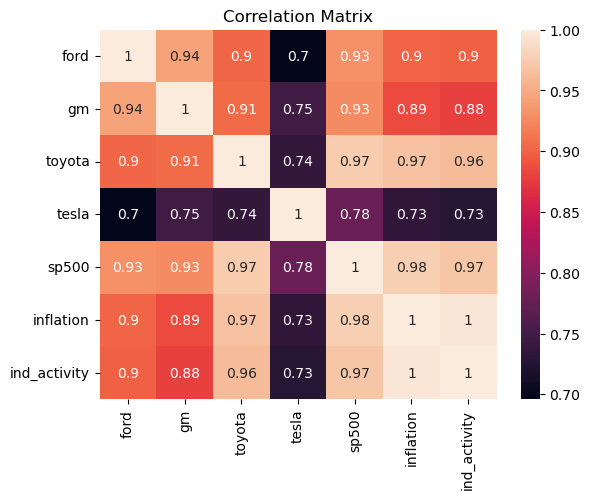

In [70]:
### Visualize correlations on a heat map
scen2_xs = scen2_inputs[xs_ren_list.keys()].rename(xs_ren_list,axis=1)
heat_corr = scen2_xs.corr()
sns.heatmap(heat_corr, annot=True)
plt.title("Correlation Matrix")
plt.show()

In [73]:
def vis_scatter(row_vars, col_vars, df):
    '''
        scatterplots with CI 
    '''
    fig, axes = plt.subplots(len(row_vars)
                             , len(col_vars)
                             , figsize=(10, 4)
                             , constrained_layout=True)
    for i, row in enumerate(row_vars):
        for j, col in enumerate(col_vars):
            ax = axes[i, j]
            sns.regplot(x=df[col], y=df[row]
                , scatter_kws={'alpha':0.5, 's':10}
                , line_kws={'color':'red'}
                , ax=ax, label=None)
            corr_coeff = np.corrcoef(df[col]
                         , df[row])[0, 1]
            ax.set_title(f'{col} | r = {corr_coeff:.2f}'
                         , fontsize=10)
            ax.tick_params(axis='both', labelsize=8)
    plt.show()

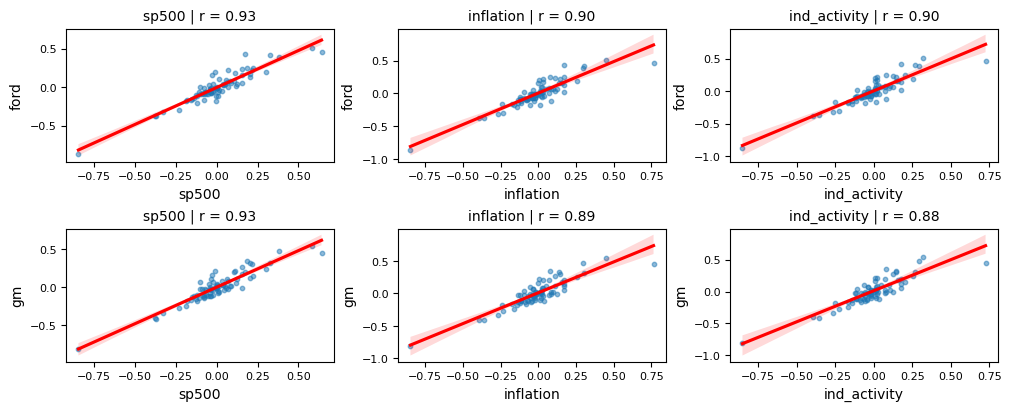

In [74]:
pair1 = ['ford', 'gm']
vars1 = ['sp500', 'inflation', 'ind_activity']
vis_scatter(row_vars = pair1, col_vars = vars1, df = scen2_xs)

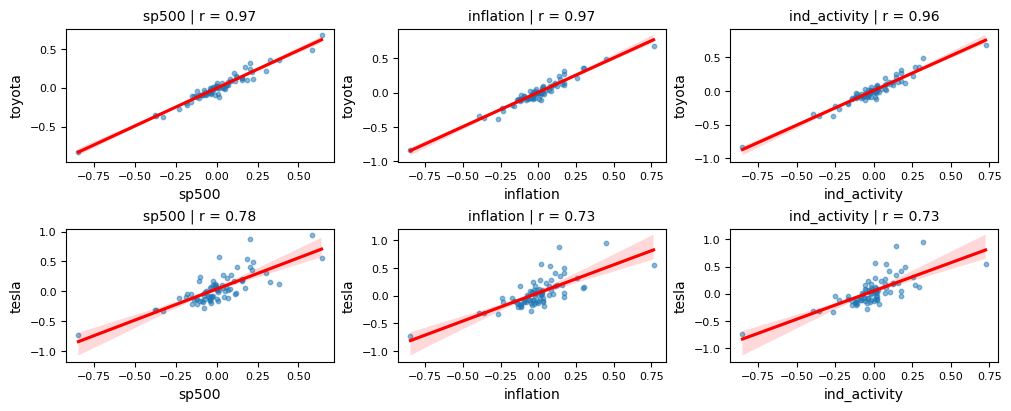

In [76]:
pair2 = ['toyota', 'tesla']
vars2 = ['sp500', 'inflation', 'ind_activity']
vis_scatter(row_vars = pair2, col_vars = vars2, df = scen2_xs)

## Build the APT Model

$
r_{\text{TSLA}} - r_f = \alpha + \beta_{\text{GSPC}} (r_{\text{GSPC}} - r_f) + \beta_{\text{CPIe}} (r_{\text{CPIe}} - r_f) + \beta_{\text{IndProd}} (r_{\text{IndProd}} - r_f) + \epsilon
$


In [28]:
all_x = ['excess_return_GSPC'
         , 'excess_return_potential_inflation'
         , 'excess_return_industrial_prod']
print(all_x)

['excess_return_GSPC', 'excess_return_potential_inflation', 'excess_return_industrial_prod']


In [35]:
def apt_model(df, stock, predictors):
    '''
    returns dataframe with fitted APT model
    '''
    y_ = df['excess_return_%s' %stock]
    X_ = df[predictors]
    X_ = sm.add_constant(X_, prepend=False)
    APT_ = sm.OLS(y_, X_)
    APT_results = APT_.fit()
    return APT_results

In [42]:
### We need only part of the output
APT_results_TSLA = apt_model(scen2_inputs, 'TSLA', all_x)
APT_results_TSLA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     excess_return_TSLA   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     41.07
Date:                Mon, 14 Apr 2025   Prob (F-statistic):           8.27e-16
Time:                        09:57:51   Log-Likelihood:                 33.479
No. Observations:                  79   AIC:                            -58.96
Df Residuals:                      75   BIC:                            -49.48
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
excess_return_GSPC                    1.7992      0.449      4.003      0.000       0.904       2.695
excess_return_potential_inflation    -0.9323      1.196     -0.780      0.438      -3.315       1.450
excess_return_industrial_prod         0.1333      1.072      0.124      0.901      -2.002       2.269
const                                 0.0321      0.019      1.702      0.093      -0.005       0.070
==============================================================================
Omnibus:                       21.376   Durbin-Watson:                   1.771
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.833
Skew:                           1.073   Prob(JB):                     4.50e-08
Kurtosis:                       5.382   Cond. No.                         86.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
APT_results_TSLA = apt_model(scen2_inputs, 'TSLA', all_x)
print(APT_results_TSLA.params
      ,APT_results_TSLA.pvalues
      ,APT_results_TSLA.conf_int())

excess_return_GSPC                   1.799250
excess_return_potential_inflation   -0.932273
excess_return_industrial_prod        0.133307
const                                0.032093
dtype: float64 excess_return_GSPC                   0.000145
excess_return_potential_inflation    0.438093
excess_return_industrial_prod        0.901365
const                                0.092936
dtype: float64                                           0         1
excess_return_GSPC                 0.903930  2.694570
excess_return_potential_inflation -3.314568  1.450023
excess_return_industrial_prod     -2.002162  2.268775
const                             -0.005475  0.069660


In [44]:
### Let's first run all of the models
APT_results_TM = apt_model(scen2_inputs, 'TM', all_x)
APT_results_F = apt_model(scen2_inputs, 'F', all_x)
APT_results_GM = apt_model(scen2_inputs, 'GM', all_x)

## Run APT models for scenario 1

In [95]:
scen1_inputs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 2023-02-28 to 2024-11-30
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   excess_return_AMD                  22 non-null     float64
 1   excess_return_INTC                 22 non-null     float64
 2   excess_return_MSFT                 22 non-null     float64
 3   excess_return_NVDA                 22 non-null     float64
 4   excess_return_SPY                  22 non-null     float64
 5   excess_return_potential_inflation  22 non-null     float64
 6   excess_return_industrial_prod      22 non-null     float64
 7   excess_return_risk_free            22 non-null     float64
dtypes: float64(8)
memory usage: 1.5+ KB


In [49]:
### Fields to use as X regressors
tech_x = ['excess_return_SPY'
         , 'excess_return_potential_inflation'
         , 'excess_return_industrial_prod']
print(tech_x)

['excess_return_SPY', 'excess_return_potential_inflation', 'excess_return_industrial_prod']


In [51]:
APT_results_AMD = apt_model(scen1_inputs, 'AMD', tech_x)
APT_results_INTC = apt_model(scen1_inputs, 'INTC', tech_x)
APT_results_MSFT = apt_model(scen1_inputs, 'MSFT', tech_x)
APT_results_NVDA = apt_model(scen1_inputs, 'NVDA', tech_x)

### Just see Alphas and Betas

In [233]:
print(APT_results_MSFT.params)

excess_return_SPY                    0.917059
excess_return_potential_inflation    0.659255
excess_return_industrial_prod       -0.482561
const                                0.007019
dtype: float64


In [234]:
### Are all the row titles consistent? Not quite.
print(APT_results_TM.params)

excess_return_GSPC                   0.653643
excess_return_potential_inflation    0.182922
excess_return_industrial_prod        0.163280
const                               -0.001901
dtype: float64


### Make row titles consistent

In [55]:
index_map = {'excess_return_SPY':'S&P500 ETF'
, 'excess_return_GSPC':'S&P500 Index'
, 'excess_return_potential_inflation':'Inflation'
, 'excess_return_industrial_prod':'Industrial Activity'
, 'const':'Alpha'}

In [56]:
### Apply mapping
x = APT_results_TSLA.params
x.rename(index_map,inplace=True)
x

S&P500 Index           1.799250
Inflation             -0.932273
Industrial Activity    0.133307
Alpha                  0.032093
dtype: float64

### help us with decisions

In [57]:
### Are 0 or 1 included in CI?
alpha = 0.05
ci = APT_results_MSFT.conf_int()
ci.columns = ['ci_lower', 'ci_upper']
ci

,ci_lower,ci_upper
excess_return_SPY,0.188197,1.645920
excess_return_potential_inflation,-3.649993,4.968503
excess_return_industrial_prod,-4.975085,4.009963
const,-0.024241,0.038279


In [58]:
def alpha_and_beta(results_df, index_map):
    '''
    Let's give ourselves a quick analysis
    '''
    z = pd.DataFrame({'Beta':results_df.params
                      , 'p-value':results_df.pvalues
                      , 'CI_lower': results_df.conf_int()[0]
                     , 'CI_upper': results_df.conf_int()[1]}
                    ).round(3)
    z = z.rename(index_map)
    z['inc 0'] = (z['CI_upper'] >= 0.0) & (z['CI_lower'] <= 0.0)
    z['inc 1'] = (z['CI_upper'] >= 1.0) & (z['CI_lower'] <= 1.0)
    return z

In [59]:
# Expect S&P includes 1, all others include 0, const does not include 1
MSFT_out = alpha_and_beta(APT_results_MSFT, index_map=index_map)
MSFT_out

,Beta,p-value,CI_lower,CI_upper,inc 0,inc 1
S&P500 ETF,0.917,0.017,0.188,1.646,False,True
Inflation,0.659,0.752,-3.650,4.969,True,True
Industrial Activity,-0.483,0.824,-4.975,4.010,True,True
Alpha,0.007,0.643,-0.024,0.038,True,False


In [60]:
def alpha_and_beta(results_df, index_map):
    '''
    Revised for fewer columns
    '''
    z = pd.DataFrame({'Beta':results_df.params
                      , 'p-value':results_df.pvalues
                      , 'CI_lower': results_df.conf_int()[0]
                     , 'CI_upper': results_df.conf_int()[1]}
                    ).round(3)
    z = z.rename(index_map)
    z['inc 0'] = (z['CI_upper'] >= 0.0) & (z['CI_lower'] <= 0.0)
    z['inc 1'] = (z['CI_upper'] >= 1.0) & (z['CI_lower'] <= 1.0)
    z.drop(['CI_lower','CI_upper'],axis=1, inplace=True)
    return z

In [61]:
# Scen 1 - tech Media

AMD_out = alpha_and_beta(APT_results_AMD, index_map=index_map)
INTC_out = alpha_and_beta(APT_results_INTC, index_map=index_map)
MSFT_out = alpha_and_beta(APT_results_MSFT, index_map=index_map)
NVDA_out = alpha_and_beta(APT_results_NVDA, index_map=index_map)
display(pd.concat([AMD_out, INTC_out, MSFT_out, NVDA_out]
                  , axis=1, keys=["AMD","INTC","MSFT","NVDA"]))

AMD                        INTC                        \
                      Beta p-value inc 0  inc 1   Beta p-value  inc 0  inc 1   
S&P500 ETF           1.322   0.130  True   True  2.244   0.015  False   True   
Inflation            0.263   0.958  True   True -0.109   0.983   True   True   
Industrial Activity  0.054   0.992  True   True -1.197   0.818   True   True   
Alpha                0.008   0.819  True  False -0.039   0.285   True  False   

                      MSFT                         NVDA                        
                      Beta p-value  inc 0  inc 1   Beta p-value  inc 0  inc 1  
S&P500 ETF           0.917   0.017  False   True  1.680   0.038  False   True  
Inflation            0.659   0.752   True   True  0.265   0.953   True   True  
Industrial Activity -0.483   0.824   True   True -1.810   0.701   True   True  
Alpha                0.007   0.643   True  False  0.069   0.045  False  False

In [62]:
# Scen 2 - Automotive
GM_out = alpha_and_beta(APT_results_GM, index_map=index_map)
F_out = alpha_and_beta(APT_results_F, index_map=index_map)
TM_out = alpha_and_beta(APT_results_TM, index_map=index_map)
TSLA_out = alpha_and_beta(APT_results_TSLA, index_map=index_map)
display(pd.concat([GM_out, F_out, TM_out, TSLA_out]
                  , axis=1, keys=["GM","F","TM","TSLA"]))

GM                            F                        \
                      Beta p-value  inc 0  inc 1   Beta p-value  inc 0  inc 1   
S&P500 Index         1.429   0.000  False  False  1.172   0.000  False   True   
Inflation           -0.791   0.152   True  False -0.793   0.147   True  False   
Industrial Activity  0.308   0.532   True   True  0.590   0.228   True   True   
Alpha               -0.003   0.771   True  False -0.005   0.522   True  False   

                        TM                         TSLA                        
                      Beta p-value  inc 0  inc 1   Beta p-value  inc 0  inc 1  
S&P500 Index         0.654   0.000  False  False  1.799   0.000  False   True  
Inflation            0.183   0.558   True  False -0.932   0.438   True   True  
Industrial Activity  0.163   0.560   True  False  0.133   0.901   True   True  
Alpha               -0.002   0.699   True  False  0.032   0.093   True  False

### Who did better?

In [228]:
# Set the stock value relative to first month
scen2_viz = pd.read_csv('scen2_stocks.csv')\
                .set_index('Date')
# Keep only the tickers
scen2_show = scen2_viz[['GM','F','TM','TSLA','GSPC']]
scen2_show = scen2_show / scen2_show.iloc[0]

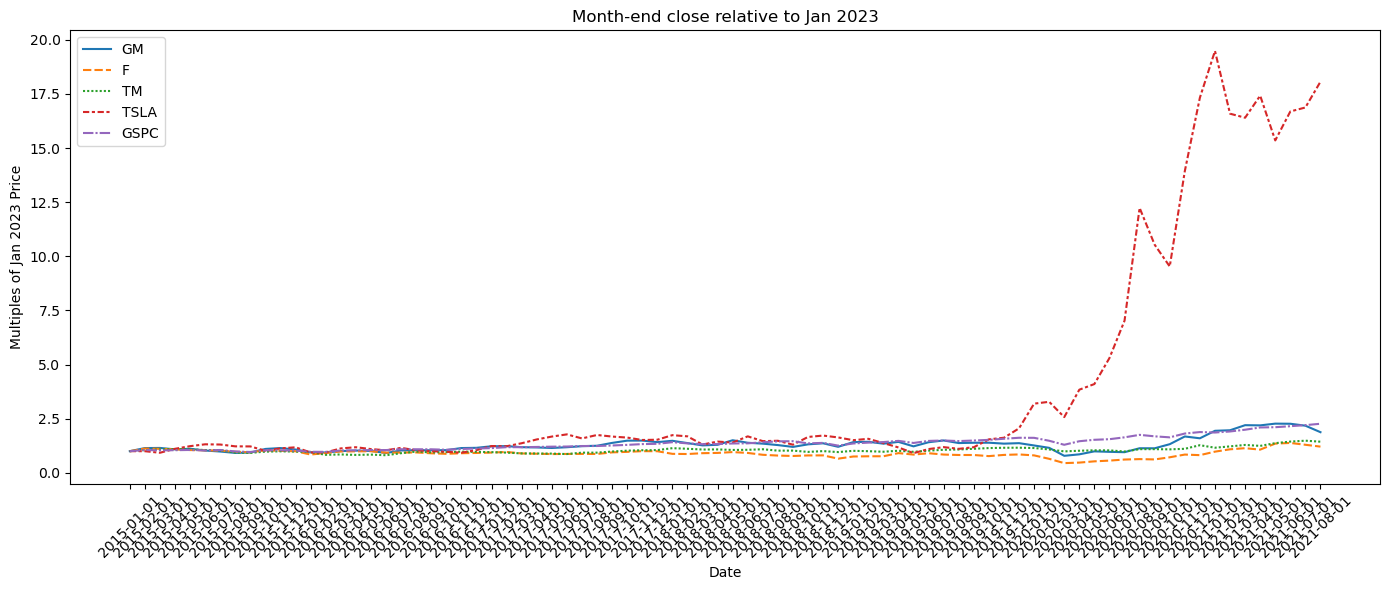

In [231]:
fig, axes = plt.subplots(figsize=(14, 6))  # 1 row, 2 columns

# First plot: Month-end close relative to Jan 2023
sns.lineplot(data=scen2_show[['GM','F','TM','TSLA','GSPC']])
axes.set_title('Month-end close relative to Jan 2023')  
axes.set_ylabel('Multiples of Jan 2023 Price')
axes.tick_params(axis='x', rotation=45, labelsize=10)  

# Second plot: Excess Returns, percent rate
# sns.lineplot(data=scen2_viz[['GM','F','TM','TSLA','GSPC']], ax=axes[1])
# axes[1].set_title('Month-over-month returns') 
# axes[1].set_ylabel('Excess Returns')
# axes[1].tick_params(axis='x', rotation=45, labelsize=10) 

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

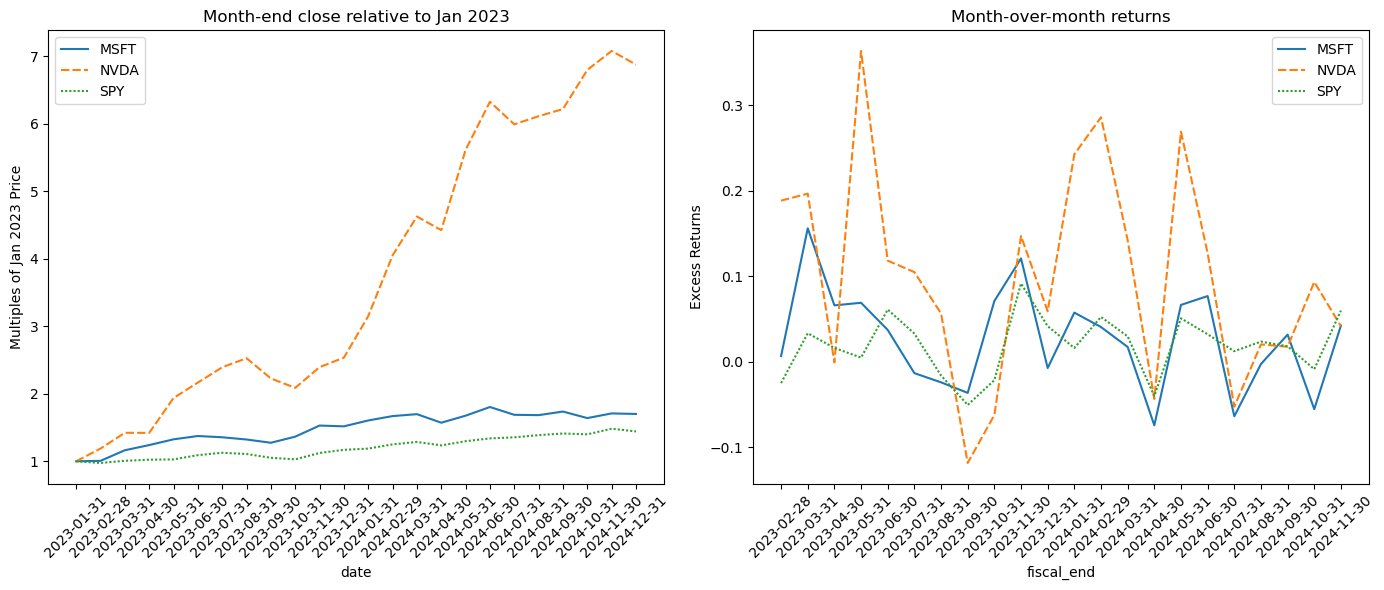

In [103]:
### Visualization confirms MSFT is blue-chip, NVDA is rapid growth